In [42]:
from typing import List, Tuple, Dict

import numpy as np
import pandas as pd
from math import sqrt
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from prophet import Prophet

import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

# Load data

In [53]:
INPUT_PATH = r'..\data\2023_09_15_freight_data.csv'

def load_data(input_path: str) -> pd.DataFrame:
    raw_data = pd.read_csv(input_path, sep=',', parse_dates=['Date'])
    raw_data.columns = [col.lower() for col in raw_data.columns]
    raw_data.rename(
        mapper={column: column.lower() for column in raw_data.columns},
    )

    return raw_data

def split_carriers(data: pd.DataFrame, carrier_list: List[str]) -> Tuple[pd.DataFrame]:
    '''splits carriers, generates data'''

    return (data.loc[data.carrier == carrier] for carrier in carrier_list)

def format_data(data: pd.DataFrame) -> pd.DataFrame:
    return data\
        .rename(
            mapper={
                'date': 'ds',
                'cost': 'y'
            },
            axis=1,
        )\
        .drop('carrier', axis=1)

def train_test_split(data: pd.DataFrame, test_length=int):
    '''preprocesses data and returns train and test dataframes'''

    clean_data = format_data(data)
    train = clean_data[:-test_length]
    test = clean_data[-test_length:]

    return train, test

tscv = TimeSeriesSplit(n_splits=2, test_size=12)

def train_prophet(train: pd.DataFrame, prophet_args: Dict=None):
    '''
    Function sets up model, trains it and predicts
    
    Returns a model and the predictions dataframe
    '''
    model = Prophet(**prophet_args)
    model.fit(train)
    predictions = predict_prophet(model)
    return model, predictions


def predict_prophet(model):
    future_data = model.make_future_dataframe(periods=12, freq='MS')
    return model.predict(future_data)


def objective_function(tscv: TimeSeriesSplit, data: pd.DataFrame, prophet_args: Dict):
    '''
    run multiple fits of the prophet using different prophet_args and report rmse
    
    Args:
        tcsv: timeseries split object to define folds
        data: dataframe
        **prophet args: keyword args to be passed to prophet
    '''

    rmse = []
    # for train_index, test_index in tscv.split(data):
    cv_train, cv_test = data.iloc[:-12], data.iloc[-12:]
    _cv_model, cv_predictions = train_prophet(cv_train, prophet_args)
    rmse.append(
        round(
            mean_squared_error(y_true=cv_test.y, y_pred=cv_predictions.yhat[-12:], squared=False), 2
        )
    )

    print(f'RMSE: {sum(rmse)/len(rmse):.2f}\n{rmse=}\n{prophet_args=}')
    return sum(rmse)/len(rmse)


def train_champion(best_params: Dict, train: pd.DataFrame, test: pd.DataFrame):
    if isinstance(best_params['seasonality_mode'], np.int64):
        best_params['seasonality_mode'] = SEASONALITY_OPTIONS[best_params['seasonality_mode']]
    print(f'{best_params=}')

    champion_model, champion_predictions = train_prophet(train, best_params)
    rmse = mean_squared_error(
        y_true=test.y,
        y_pred=champion_predictions.yhat[-12:],
        squared=False,
    )
    return champion_model, champion_predictions, rmse

def plot_predictions(train, test, model, carrier, rmse=None) -> None:
    '''plots a model for a given set of data'''
    predictions = predict_prophet(model)
    fig = model.plot(predictions, xlabel='date', ylabel='feight_costs')
    plt.plot(test.ds, test.y, color='red', label='actual test values')
    plt.plot(train.ds, train.y, color='green', label='actual train values')
    plt.title(f'{carrier} model predictions with Prophet')
    if rmse:
        plt.suptitle(f'RMSE: ±{rmse:.0f}', y=1.05)
    plt.legend()
    plt.show()

def plot_components(model, predictions, carrier):
    model.plot_components(predictions)
    plt.title(f'{carrier} time series components')
    plt.legend()
    plt.show()

In [3]:
raw_data = load_data(INPUT_PATH)
ups_data, fdxg_data = split_carriers(raw_data, ['UPS', 'FDXG'])

ups_train, ups_test = train_test_split(ups_data, 12)
fdxg_train, fdxg_test = train_test_split(fdxg_data, 12)

# Tune models

# Define search space for hyper parameters

In [48]:
SEASONALITY_OPTIONS = ['additive', 'multiplicative']
from functools import partial
from hyperopt import hp, fmin, tpe

# define all possible combinations to be tested
search_space = {
    'changepoint_prior_scale': hp.uniform('changepoint_prior_scale', .001, .5),
    'seasonality_prior_scale': hp.uniform('seasonality_prior_scale', .01, 10.),
    'seasonality_mode': hp.choice('seasonality_mode', SEASONALITY_OPTIONS),
    'changepoint_range': hp.uniform('changepoint_range', .5, .99),
}


# Run tuning on UPS

In [44]:
import random

random.seed(20230920)
# run cv search and see which parameters fit best for this time series
ups_best_param = fmin(
    fn=partial(objective_function, tscv, ups_train),
    space=search_space,
    algo=tpe.suggest,
    max_evals=20
)

RMSE: 19540.82                                        
rmse=[19540.82]
prophet_args={'changepoint_prior_scale': 0.1891538678224783, 'changepoint_range': 0.6876031056864097, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.100007620875011}
RMSE: 4461.37                                                         
rmse=[4461.37]
prophet_args={'changepoint_prior_scale': 0.026100001509346684, 'changepoint_range': 0.9682090220741384, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.8624149580754485}
RMSE: 379267.86                                                       
rmse=[379267.86]
prophet_args={'changepoint_prior_scale': 0.16599898790740886, 'changepoint_range': 0.9466415369995633, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.1752723101548024}
RMSE: 6315.15                                                        
rmse=[6315.15]
prophet_args={'changepoint_prior_scale': 0.19757081198501766, 'changepoint_range': 0.7722415540655799, 'seasonality_mod

## Train and evaluate the best model for UPS

best_params={'changepoint_prior_scale': 0.026100001509346684, 'changepoint_range': 0.9682090220741384, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.8624149580754485}
Best performing model for UPS has RMSE: 6167.61


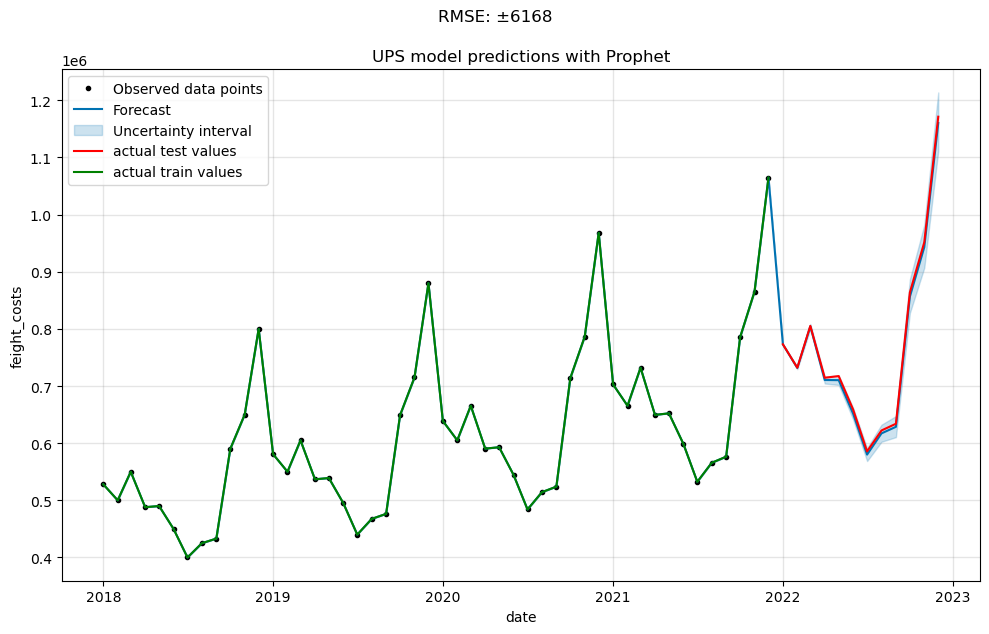

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


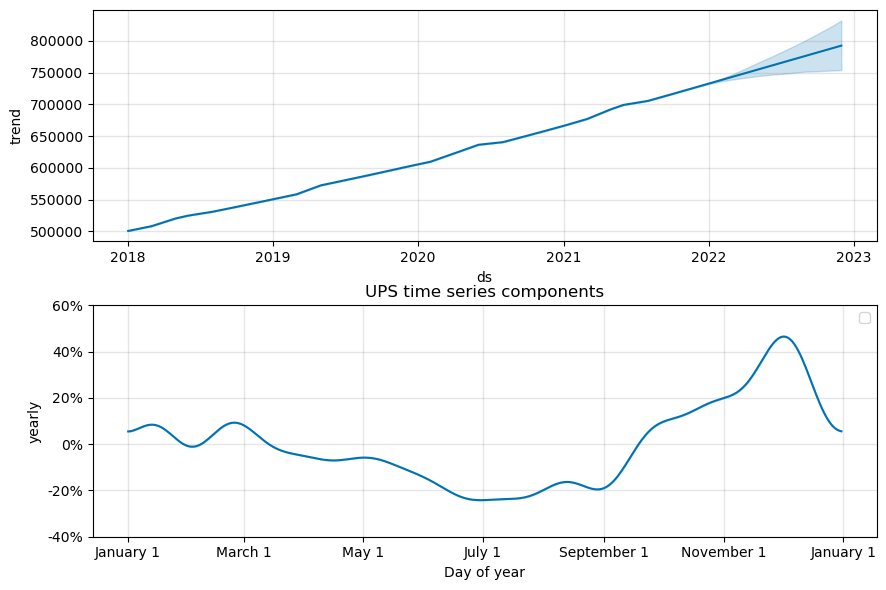

In [54]:
ups_champion_model, ups_champion_predictions, ups_rmse = train_champion(ups_best_param, ups_train, ups_test)
print(f'Best performing model for UPS has RMSE: {ups_rmse:.2f}')
plot_predictions(ups_train, ups_test, ups_champion_model, 'UPS', ups_rmse)
plot_components(ups_champion_model, ups_champion_predictions, 'UPS')

# FDXG predictions

In [23]:
random.seed(20230920)

nd_ups_best_param = fmin(
    fn=partial(objective_function, tscv, nd_ups_train),
    space=search_space,
    algo=tpe.suggest,
    max_evals=20
)

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

RMSE: 28646.29                                        
rmse=[28646.29]
prophet_args={'changepoint_prior_scale': 0.49808953209925855, 'changepoint_range': 0.5104931647516746, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 8.342212914282849}
RMSE: 52889.07                                                        
rmse=[52889.07]
prophet_args={'changepoint_prior_scale': 0.19118900331781888, 'changepoint_range': 0.759318632899723, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 8.380637336119287}
RMSE: 24448.35                                                        
rmse=[24448.35]
prophet_args={'changepoint_prior_scale': 0.04911962590578982, 'changepoint_range': 0.6123410353831695, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.6600115597159424}
RMSE: 19238.46                                                        
rmse=[19238.46]
prophet_args={'changepoint_prior_scale': 0.3244611900077165, 'changepoint_range': 0.7935404731091454, 'seasonality_mode': 'mu

best_params={'changepoint_prior_scale': 0.07529451842441685, 'changepoint_range': 0.7651951236522654, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5.336226938976147}
Best performing model for FDXG has RMSE: 3253.16


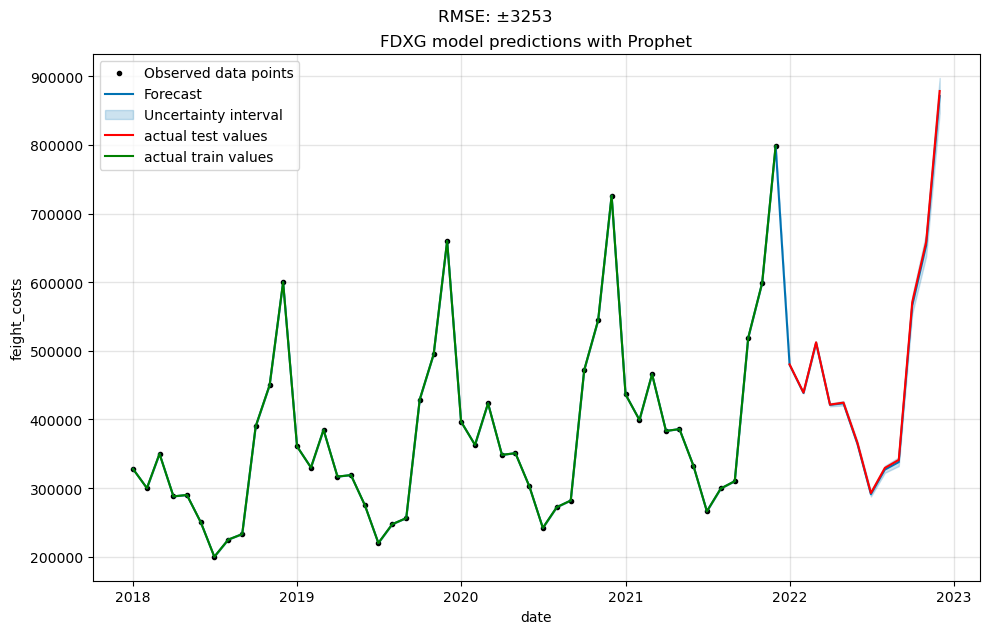

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


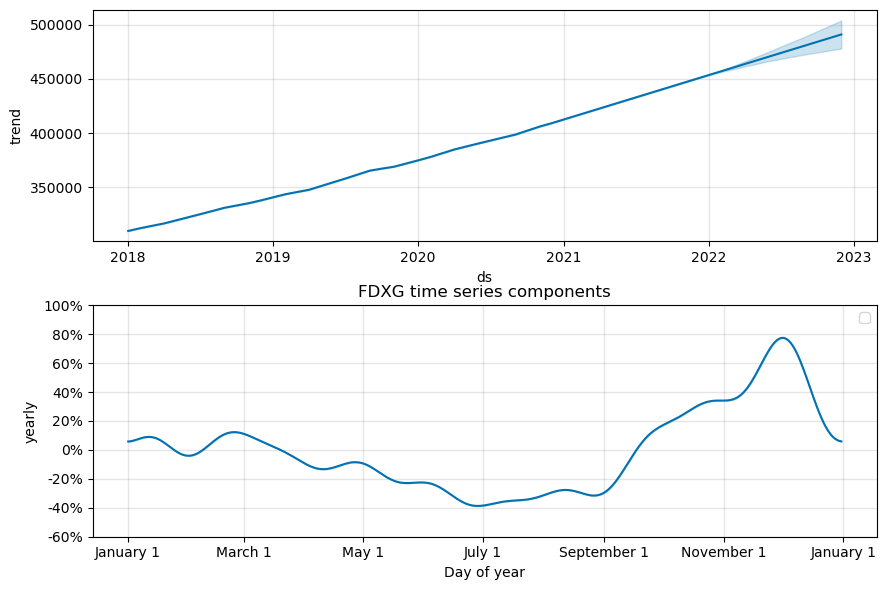

In [55]:
fdxg_champion_model, fdxg_champion_predictions, fdxg_rmse = train_champion(fdxg_best_param, fdxg_train, fdxg_test)
print(f'Best performing model for FDXG has RMSE: {fdxg_rmse:.2f}')
plot_predictions(fdxg_train, fdxg_test, fdxg_champion_model, 'FDXG', fdxg_rmse)
plot_components(fdxg_champion_model, fdxg_champion_predictions, 'FDXG')

# Training with the new data from another client

In [14]:
new_data_path = r'..\data\2023_09_20_freight_data.csv'

new_data = load_data(new_data_path)
new_data.shape

(67, 3)

In [16]:
new_data.describe()

,date,cost
count,67,6.700000e+01
mean,2020-09-30 13:15:13.432835840,8.834413e+05
min,2018-01-01 00:00:00,3.987065e+05
25%,2019-05-16 12:00:00,6.716230e+05
50%,2020-10-01 00:00:00,8.964149e+05
75%,2022-02-15 00:00:00,1.056033e+06
max,2023-07-01 00:00:00,1.458451e+06
std,NaN,2.506882e+05


In [18]:
new_data.dtypes

carrier            object
date       datetime64[ns]
cost              float64
dtype: object

In [58]:
nd_train, nd_test = train_test_split(new_data, 12)

random.seed(20230920)
# run cv search and see which parameters fit best for this time series
nd_best_param = fmin(
    fn=partial(objective_function, tscv, nd_train),
    space=search_space,
    algo=tpe.suggest,
    max_evals=40
)

RMSE: 618917.54                                       
rmse=[618917.54]
prophet_args={'changepoint_prior_scale': 0.44179784597711164, 'changepoint_range': 0.9310917325121197, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 6.555201529085341}
RMSE: 208114.71                                                        
rmse=[208114.71]
prophet_args={'changepoint_prior_scale': 0.3264036852953851, 'changepoint_range': 0.6379653397632147, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 8.255888978724911}
RMSE: 201932.74                                                        
rmse=[201932.74]
prophet_args={'changepoint_prior_scale': 0.10736281634830395, 'changepoint_range': 0.6925718968886333, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.4111997325642376}
RMSE: 439283.52                                                        
rmse=[439283.52]
prophet_args={'changepoint_prior_scale': 0.48012101585677636, 'changepoint_range': 0.8209579641942916, 'seasonality_mo

best_params={'changepoint_prior_scale': 0.36738338222880057, 'changepoint_range': 0.6043777322428385, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.029819840797510135}
Best performing model for new data has RMSE: 131907.77


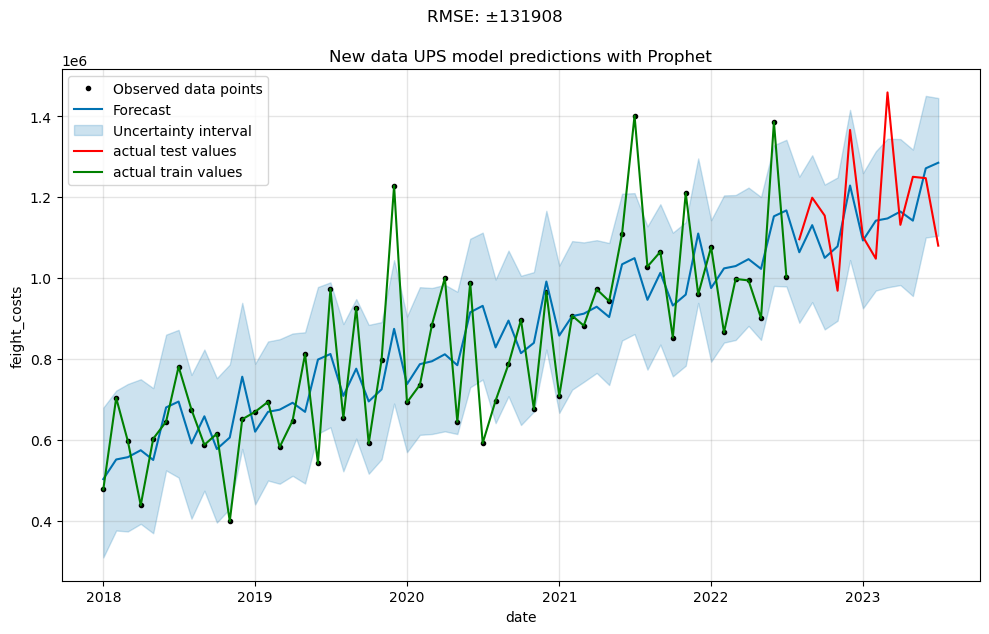

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


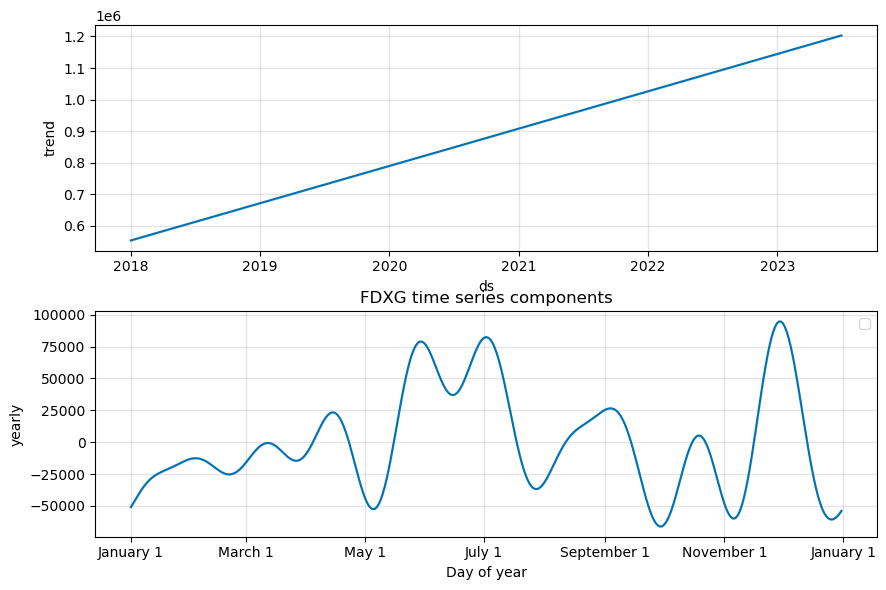

In [59]:
nd_champion_model, nd_champion_predictions, nd_rmse = train_champion(nd_best_param, nd_train, nd_test)
print(f'Best performing model for new data has RMSE: {nd_rmse:.2f}')
plot_predictions(nd_train, nd_test, nd_champion_model, 'New data UPS', nd_rmse)
plot_components(nd_champion_model, nd_champion_predictions, 'FDXG')

In [60]:
print(f'{ups_best_param=}')
print(f'Best performing model for UPS has RMSE: {ups_rmse:.2f}')
print(f'{fdxg_best_param=}')
print(f'Best performing model for FDXG has RMSE: {fdxg_rmse:.2f}')
print(f'{nd_best_param=}')
print(f'Best performing model for FDXG has RMSE: {nd_rmse:.2f}')

ups_best_param={'changepoint_prior_scale': 0.026100001509346684, 'changepoint_range': 0.9682090220741384, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.8624149580754485}
Best performing model for UPS has RMSE: 6167.61
fdxg_best_param={'changepoint_prior_scale': 0.07529451842441685, 'changepoint_range': 0.7651951236522654, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5.336226938976147}
Best performing model for FDXG has RMSE: 3253.16
nd_best_param={'changepoint_prior_scale': 0.36738338222880057, 'changepoint_range': 0.6043777322428385, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.029819840797510135}
Best performing model for FDXG has RMSE: 131907.77
